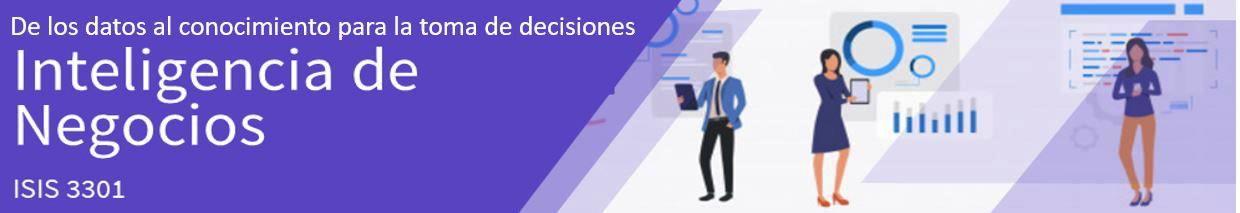

# Machine Learning supervisado, Regresión

El objetivo de este notebook es dar a conocer las principales etapas y consideraciones al entrenar un modelo de regresión lineal que permita predecir o estimar una variable continua. Se toma nuevamente el caso de estudio de SpotiAlpes buscando estimar el nivel de *danceability* de una canción. Se aborda el proceso general de entrenamiento de modelos de regresión, su validación en términos de las métricas de error más comunes y de la comprobación de supuestos, así como la interpretación de dichos modelos.

Este notebook se encuentra dividido en las siguientes secciones:

1. Carga de los datos
2. Entendimiento y limpieza de datos
3. Particionamiento del conjunto de datos en entrenamiento y prueba
4. Entrenamiento de un primer modelo
5. Entrenamiento de un segundo modelo aplicando normalización
6. Validación de los supuestos de la regresión
7. Persistencia del modelo y estimación para el nuevo conjunto de datos

Para la carga y manipulación de datos se utiliza la libreria **Pandas** (https://pandas.pydata.org/) y para la visualización **Matplotlib** (https://matplotlib.org/) y **Seaborn** (https://seaborn.pydata.org/). El algoritmo de regresión logística y funcionalidades complementarias se encuentran implementados en la libreria **Scikit-Learn** (https://scikit-learn.org/).

## Caso

SpotiAlpes es una empresa que brinda servicios gratuitos de transmisión de música y está interesada en explorar opciones para generar valor al negocio a partir de los datos que ha recopilado a lo largo de los años. En esta tercera fase del análisis se desea evaluar la viabilidad de estimar que tan bailable es una canción a partir de sus demás atributos. Esto es importante debido a que durante la fase de clustering se determinó que las canciones bailables tienden a ser más populares, y dado que el nivel de *danceability* de una canción es actualmente determinado de forma manual por parte de expertos, automatizar este proceso podría ser muy útil al momento de determinar si una canción debe o no ser incluida dentro de la plataforma dado su potencial de popularidad.

Como tarea complementaria, la empresa ha solicitado realizar la estimación de la *danceability* de un nuevo conjunto de canciones que serán próximamente publicadas en la plataforma usando el mejor modelo encontrado.

## Los datos

Se trabaja con un conjunto de datos que contiene las canciones disponibles en SpotiAlpes. El conjunto de datos original contiene alrededor de 600K canciones con diferentes caracteristicas musicales. Se trabaja sobre una versión depurada con solo 100K canciones. Esta versión incluye nuevas columnas que fueron creadas por un grupo de ingenieros de datos de la empresa.

Los datos originales se pueden encontrar aquí: *https://www.kaggle.com/datasets/yamaerenay/spotify-dataset-19212020-600k-tracks*

In [67]:
import numpy as np
import pandas as pd

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import scipy.stats as stats

In [68]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

## 1. Carga de los datos

In [69]:
df_tracks = pd.read_csv('./data/PrepTracksRegresionHistoricos.csv', sep=',', encoding = 'utf-8', index_col=0)

In [70]:
df_tracks.shape

(99500, 21)

In [71]:
df_tracks.sample(5)

,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,loudness,mode,decibel_range,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,first_artist,second_artist
id,,,,,,,,,,,,,,,,,,,,,
0TWnQ8bOYjV3LB6NPigp11,Cosa sarà,29.0,259147,0.0,"[""Lucio Dalla"", ""Francesco De Gregori""]","['25MkkfEousyfp2eyh38FUl', '16FJYC4FqKhZXiXIzM...",1978-03-10,0.187809,52.600,-9.205,M,NaN,0.0784,0.0980,0.000230,0.1380,0.777,84.159,4.0,Lucio Dalla,Francesco De Gregori
3cCjEDTIWSNr5stzGhiRWI,Dy-Na-Mi-Tee,55.0,217467,0.0,"[""Ms. Dynamite""]",['42qLC3FgtazA9AvaIoiP62'],2002-01-01,0.225155,57.600,-8.615,m,NaN,0.0565,0.1070,0.000000,0.0852,0.597,158.475,4.0,Ms. Dynamite,NaN
1U8TBiWXkdpcDuTFlguVnU,"Det svarta guldet, del 16",22.0,51253,0.0,"[""Tintin"", ""Tomas Bolme"", ""Bert-Åke Varg""]","['6aMD1KAa5i3Myy61cR8FiW', '7HjbJ8V87zrxkSzL1K...",1980-06-26,0.225496,47.100,-18.810,m,NaN,0.9150,0.3340,0.000000,0.0740,0.391,76.099,4.0,Tintin,Tomas Bolme
7d3BFlPA0OzjPnGJOBBEkR,The Music Room - 2015 Remaster,3.0,162227,0.0,"[""Miles Davis"", ""Michel Legrand""]","['0kbYTNQb4Pb1rPbbaF0pT4', '1EtE0iSY6iFlN9L9c5...",2002-08-20,0.101751,0.925,-26.716,M,NaN,0.3860,0.9220,0.000107,0.2290,0.128,75.423,5.0,Miles Davis,Michel Legrand
1cYA3YfOwvpaw7Tj87GpHT,Magic of Love,40.0,221760,0.0,"[""Perfume""]",['2XMxWKPKCxoLkSdpCViCnr'],2013-01-01,0.340961,94.100,-2.378,m,NaN,0.0453,0.0197,0.000000,0.3510,0.928,127.989,4.0,Perfume,NaN


In [72]:
df_tracks_new = pd.read_csv('./data/PrepTracksRegresionRecientes.csv')

In [73]:
df_tracks_new.shape

(500, 21)

In [74]:
df_tracks_new.sample(5)

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,energy,loudness,mode,decibel_range,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,first_artist,second_artist
208,7zqdXA7eC2dafnpt7toXtE,パッシュ,13.0,200000,0.0,"[""THE MINKS""]",['4StWZYlovbOOPkSAWjYZHu'],1989-07-21,79.00,-8.822,M,NaN,0.0366,0.00511,0.000000,0.0870,0.938,109.911,4.0,THE MINKS,NaN
277,1gBwqqhLZ5si3pEIdlpTYI,Sugar Mama Blues,16.0,178233,0.0,"[""Sonny Boy Williamson I""]",['1qxTNsrSi4fNXVO0sbMsl4'],Year 1945,9.56,-15.994,M,NaN,0.0809,0.98000,0.000596,0.0922,0.665,85.948,4.0,Sonny Boy Williamson I,NaN
241,45IJCUmR30YR8SBiBw14bD,Just as Long as We Have Love,38.0,245867,0.0,"[""The Spinners""]",['5fbhwqYYh4YwUoEs582mq5'],Year 1975,35.20,-10.732,m,NaN,0.0308,0.83100,0.000055,0.0609,0.261,137.985,4.0,The Spinners,NaN
405,3elkEyvl4O0e8gswWkZYAX,Sigo Pensando En Ti,47.0,209213,0.0,"[""Volumen X""]",['1g6uqdHXhTcNgy9qoGC5Fd'],2003-03-02,63.40,-6.442,M,NaN,0.0504,0.24600,0.000000,0.1470,0.913,143.955,4.0,Volumen X,NaN
486,425q8r7f5lxmR5JM8qNfOH,Un Instante,11.0,124109,0.0,"[""Alberto Wolf""]",['0PxROnBgJGsMQw3QoWkpwT'],1985-10-01,38.70,-9.580,m,NaN,0.0295,0.66200,0.000015,0.1050,0.366,119.374,4.0,Alberto Wolf,NaN


## 2. Entendimiento y limpieza de los datos

Para entrenar un modelo de regresión lineal todos los atributos deben ser numéricos. Con ayuda de los expertos, se seleccionan las variables numéricas que se consideran más importantes para la estimación de `danceability`.  
  
Adicionalmente, se debe asegurar que tanto para las variables (features) a ser consideradas para el entrenamiento del modelo como para la variable a estimar (objetivo) se debe asegurar que no existan valores vacíos. Se decide eliminar los registros que tengan valores vacíos en las variables a considerar dado que el experto recomienda no realizar ninguna imputación.

<span style="color: red;">Recuerde que la eliminación de registros debe ser considerada la última opción durante el proceso de limpieza de datos.</span>

In [75]:
#Variables definidas de forma conjunta con el experto
features = ['energy', 'loudness', 'acousticness', 'instrumentalness', 'valence']

In [76]:
#Revisión del porcentaje de valores nulos (vacíos) en las características seleccionadas para la regresión.
df_tracks[['danceability'] + features].isnull().sum() / df_tracks.shape[0]

danceability        0.001940
energy              0.000935
loudness            0.001065
acousticness        0.000884
instrumentalness    0.001005
valence             0.001005
dtype: float64

In [77]:
# Eliminar las canciones con algún dato vacío
# Antes de realizar este paso recuerde generar 
# un reporte para los expertos con las canciones que quitó del conjunto de datos a analizar
df_tracks = df_tracks.dropna(subset = ['danceability'] + features)
df_tracks_new = df_tracks_new.dropna(subset = features)

In [78]:
df_tracks.shape

(99013, 21)

In [79]:
df_tracks_new.shape

(488, 21)

In [80]:
df_tracks[['danceability'] + features].isnull().sum() / df_tracks.shape[0]

danceability        0.0
energy              0.0
loudness            0.0
acousticness        0.0
instrumentalness    0.0
valence             0.0
dtype: float64

### 2.1. Búsqueda de relaciones entre variables

Si se logra visualizar o cuantificar una alta correlación entre las variables a usar para el entrenamiento del modelo con respecto a la variable objetivo, se podrán soportar las decisiones del experto con base en la evidencia.

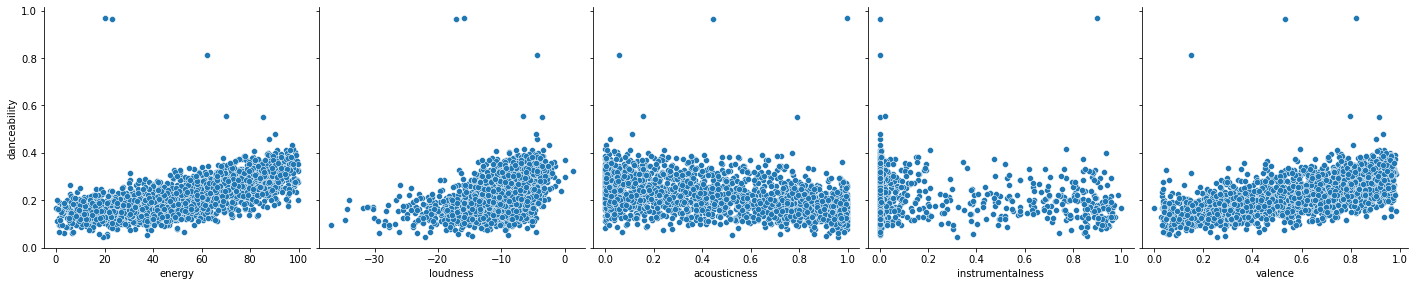

In [81]:
sns.pairplot(df_tracks.sample(2000), height = 4, y_vars = 'danceability', x_vars = features, kind = 'scatter')

### 2.2. Búsqueda de relaciones entre los atributos

**Importante:** La regresión lineal asume que las variables de entrada son independientes entre ellas (a nivel práctico que no se encuentran altamente correlacionados).
Se revisará ese supuesto con la siguiente gráfica.

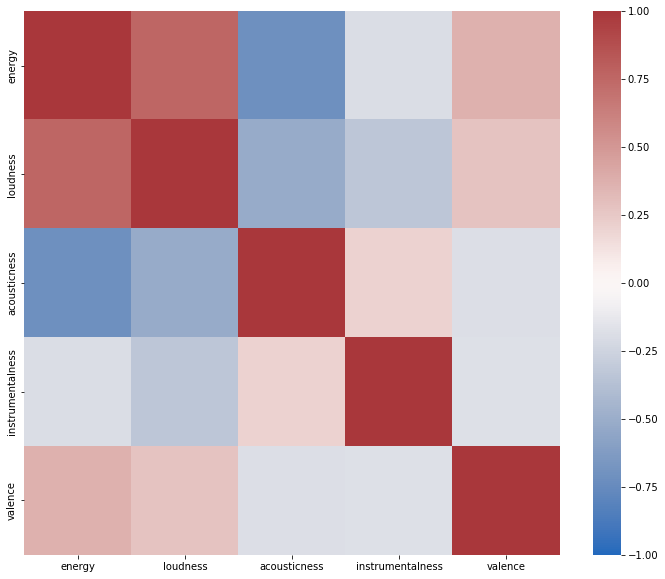

In [82]:
plt.figure(figsize = (12, 10))
sns.heatmap(df_tracks[features].corr(), cmap = 'vlag', vmin = -1, vmax = 1)

Un buen punto de corte (empírico) para decidir si descartar una variable debido a su alta correlación con otra es ~$|0.8|$.Este valor depende del contexto.

## 3. Particionamiento del conjunto de datos en entrenamiento y prueba

Se desea construir un modelo que se ajuste bien a los datos de entrenamiento, pero que además se comporte de forma similar con datos desconocidos.

Metodológicamente, una práctica común para validar esto es separando el conjunto de datos etiquetado en dos partes: entrenamiento y prueba. La proporción reservada para probar el modelo es definida por el analista, pero un valor común es 30%.

In [83]:
X_train, X_test, y_train, y_test = train_test_split(df_tracks[features], df_tracks['danceability'], test_size = 0.3, random_state = 1)

In [84]:
X_train.shape, y_train.shape

((69309, 5), (69309,))

In [85]:
X_test.shape, y_test.shape

((29704, 5), (29704,))

## 4. Entrenamiento de un primer modelo

Recordemos los visto en cursos previos sobre la regresión lineal y veámos como calcularla utilizando sklearn.

In [87]:
regression = LinearRegression()

In [88]:
regression.fit(X_train, y_train)

LinearRegression()

### 4.1. Interpretación de los coeficientes y del intercepto

Los coeficientes de la regresión brindan una intuición del impacto o la fuerza de una característica en la predicción/estimación de la variable objetivo.

In [28]:
pd.DataFrame({'columns': features, 'coef': regression.coef_})

,columns,coef
0,energy,0.001872
1,loudness,-0.001520
2,acousticness,0.008154
3,instrumentalness,0.002925
4,valence,0.114988


Note que las características ("features") se encuentran en diferentes escalas, rangos o grados de magnitud, razón por la cuál la interpretación de los coeficientes puede no ser la correcta. Si bien este no es el escenario, otro posible problema del uso de características en diferentes escalas es que el modelo se puede sesgar hacia las que tienen mayores escalas, basando su estimación mayoritariamente en estas y tendiendo a descartar las otras.

Por otro lado, el intercepto suele ser útil para determinar un valor de base en la estimación, en este caso un nivel mínimo de `danceability` incluso si todas las características tuvieran valores iguales a cero.

In [89]:
regression.intercept_

0.03566284277599974

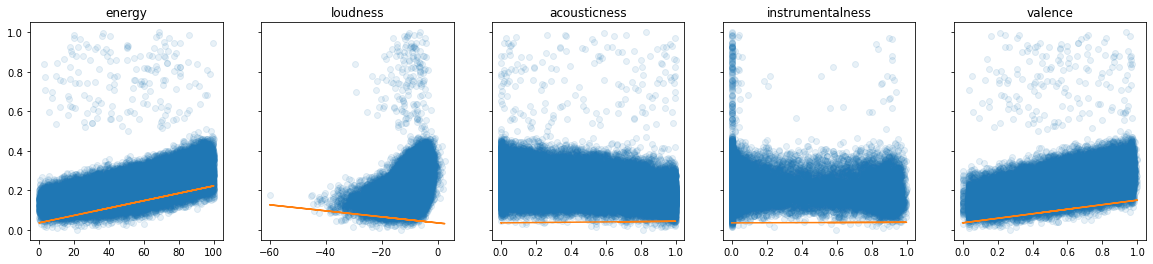

In [90]:
f, axs = plt.subplots(1, len(features), sharey = True, figsize = (20, 4))

for i in range(len(features)):
    col = features[i]
    x = X_train[col]
    m = regression.coef_[i]
    b = regression.intercept_

    axs[i].plot(x, y_train, 'o', alpha = 0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)

### 4.2. Validación del modelo

**Mean Absolute Error (MAE)**

$$ MAE = {1 \over n}{\sum_{i=1}^n {|y_{i} - y_{i}'|} } $$

In [91]:
print('Train:', mean_absolute_error(y_train, regression.predict(X_train)))
print('Test:', mean_absolute_error(y_test, regression.predict(X_test)))

Train: 0.03314721261915647
Test: 0.03332610409911353


**Root Mean Squeared Error (RMSE)**

$$ RMSE = {1 \over n}{\sum_{i=1}^n {(y_{i} - y_{i}')^2} } $$

**Revisa la métrica MAPE**, puede ser muy interesante para explicar mejor a un experto el resultado.

In [92]:
print('Train:', np.sqrt(mean_squared_error(y_train, regression.predict(X_train))))
print('Test:', np.sqrt(mean_squared_error(y_test, regression.predict(X_test))))

Train: 0.04858645157902375
Test: 0.04809195951049388


**Análisis del error**

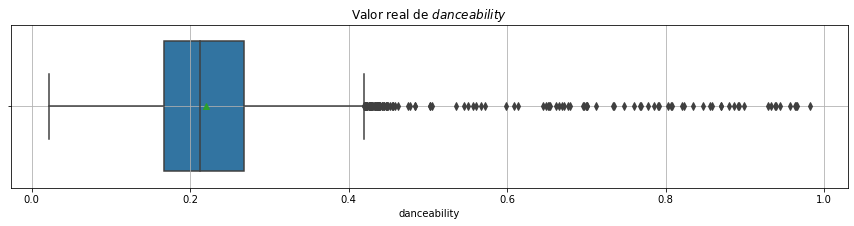

In [93]:
plt.figure(figsize = (15, 3))
sns.boxplot(x = y_test, showmeans = True, orient = 'h')
plt.title('Valor real de $\t{danceability}$')
plt.grid()
plt.show()

In [94]:
y_test.describe()

count    29704.000000
mean         0.220194
std          0.075121
min          0.021395
25%          0.166911
50%          0.212818
75%          0.267995
max          0.981546
Name: danceability, dtype: float64

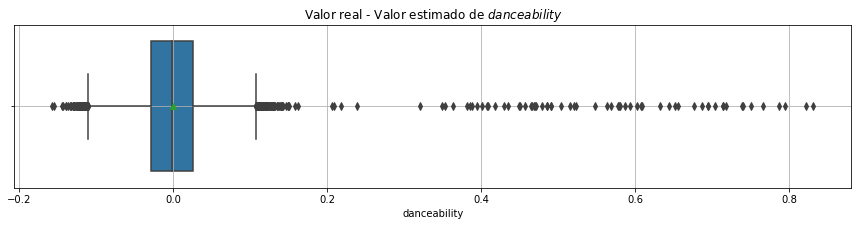

In [95]:
plt.figure(figsize = (15, 3))
sns.boxplot(x = (y_test - regression.predict(X_test)), showmeans = True, orient = 'h')
plt.title('Valor real - Valor estimado de $\t{danceability}$')
plt.grid()
plt.show()

In [36]:
abs(y_test - regression.predict(X_test)).describe()

count    29704.000000
mean         0.033326
std          0.034673
min          0.000002
25%          0.012996
50%          0.027260
75%          0.046560
max          0.831377
Name: danceability, dtype: float64

Se podría decir que los resultados de este primer modelo son aceptables dado que:
1) Las métricas de error para el dataset de entrenamiento y prueba son muy similares. No se evidencian problemas de sobreajuste (overfitting).
2) Para el conjunto de prueba los valores de la variable objetivo están centrados en $0.22 \pm 0.075$, mientras que el 50% de los errores de estimación del modelo se encuentran entre $\pm 0.027$.

## 5. Entrenamiento de un segundo modelo aplicando normalización

Scikit-Learn permite integrar el proceso de normalización de características dentro del proceso de entrenamiento/predicción de los modelos mediante el uso de Pipelines. Un Pipeline permite ejecutar de forma secuencial un conjunto de transformaciones de datos, selección de variables, entre otros, seguido del paso de entrenamiento o predicción.

La documentación oficial de Pipelines se puede encontrar aquí: https://scikit-learn.org/stable/modules/compose.html.

In [37]:
pipeline = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]
)

In [38]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [39]:
pd.DataFrame({'columns': features, 'coef': pipeline['model'].coef_})

,columns,coef
0,energy,0.047336
1,loudness,-0.007706
2,acousticness,0.002857
3,instrumentalness,0.000783
4,valence,0.029798


In [40]:
pipeline['model'].intercept_

0.21987406633233972

In [41]:
print('MAE:')
print('Train:', mean_absolute_error(y_train, pipeline.predict(X_train)))
print('Test:', mean_absolute_error(y_test, pipeline.predict(X_test)))
print('\nRMSE:')
print('Train:', np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train))))
print('Test:', np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test))))

MAE:
Train: 0.03314721261915647
Test: 0.03332610409911354

RMSE:
Train: 0.04858645157902375
Test: 0.04809195951049388


Si bien las métricas de error no presentan cambios importantes, los coeficientes del modelo de regresión pueden ser comparados directamente dado que todas las características se encuentran en la misma escala. Recuerde que:
1) El signo del coeficiente representa la dirección de la relación entre la característica correspondiente y la variable objetivo. Signos positivos implican que si el valor de la característica aumenta el valor de la variable objetivo también aumentará, mientras que signos negativos indican que si el valor de la feature aumenta el valor de la variable objetivo disminuirá.
2) El valor del coeficiente cuantifica la magnitud de la relación implicando que un aumento o disminución (dependiendo del signo del coeficiente) en una unidad de la característica correspondiente representará un cambio promedio equivalente al valor del coeficiente en la variable de respuesta, asumiendo que los valores de las demás características permanezcan constantes.

## 6. Validación de supuestos de la regresión

Este paso es importante para poder interpretar de forma apropiada el modelo construido.

### 6.1. Colinealidad
Es necesario que las columnas utilizadas no tengan (o tengan muy poca) colinealidad (correlación).

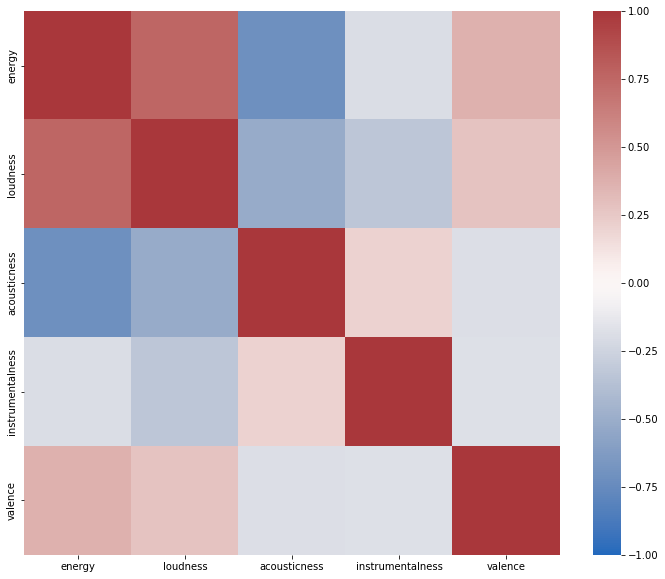

In [42]:
plt.figure(figsize = (12, 10))
sns.heatmap(df_tracks[features].corr(), cmap = 'vlag', vmin = -1, vmax = 1)

**TODO:** Si bien la correlación entre `energy`, `loudness` y `acousticness` no es tan alta, valdría la pena entrenar un modelo que tenga en cuenta solo una de estos tres atributos.

In [43]:
features2 = ['energy', 'valence']

### 7.2. Linealidad
Es necesario que la relación entre cada variable explicativa y la varable objetivo sea lineal. Muchas veces la mejor forma de comprobarlo es visualmente:  
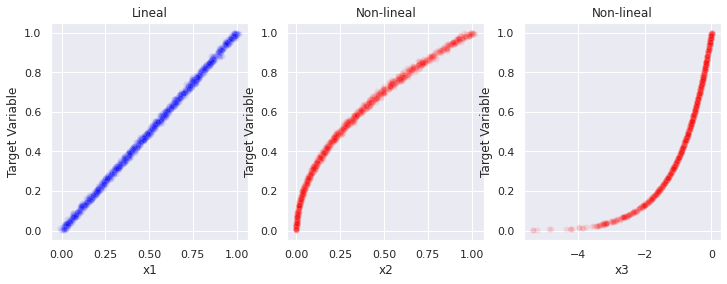

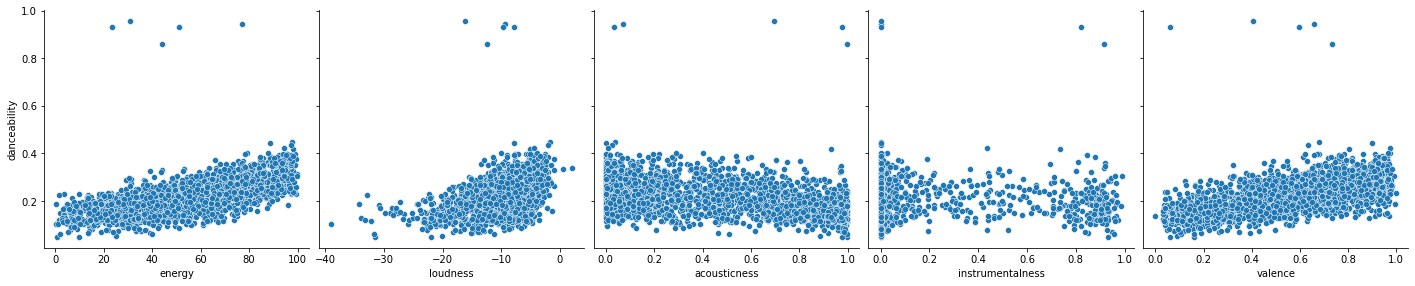

In [44]:
sns.pairplot(df_tracks.sample(2000), height = 4, y_vars = 'danceability', x_vars = features, kind = 'scatter')

¿Es posible que `energy` y `danceability` tengan una relación no lineal?

In [45]:
pipeline = Pipeline(
    [
        ('poly', PolynomialFeatures(degree = 2, include_bias = False)),
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]
)

In [46]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('scaler', StandardScaler()), ('model', LinearRegression())])

In [47]:
print('MAE:')
print('Train:', mean_absolute_error(y_train, pipeline.predict(X_train)))
print('Test:', mean_absolute_error(y_test, pipeline.predict(X_test)))
print('\nRMSE:')
print('Train:', np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train))))
print('Test:', np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test))))

MAE:
Train: 0.030795565442287093
Test: 0.030911777931144045

RMSE:
Train: 0.046184644511840345
Test: 0.04559591738701013


Se observa una reducción del error por lo que se podría asumir que si existe una relación no lieal de tipo cuadrático entre `energy` y `danceability`.

### 7.3. Normalidad en los errores

Otro supuesto de la regresión lineal es que los errores tienen una distribución normal. Para esto se puede usar:
* Grafico de dispersión entre los errores y el valor predicho
* Grafico Q-Q

**Dispersión**
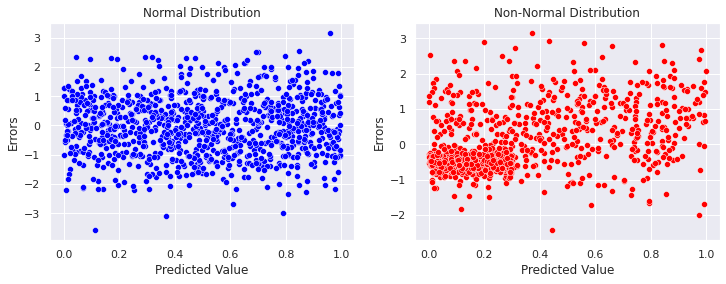

**Q-Q Plots**
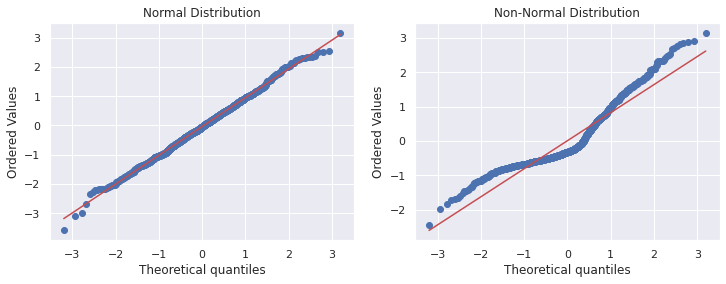

In [48]:
errors = (pipeline.predict(X_train) - y_train).values

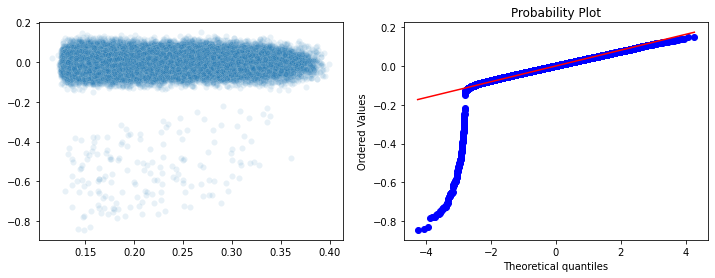

In [49]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

# Dispersión
sns.scatterplot(x = pipeline.predict(X_train), y = errors, alpha = 0.1, ax = axes[0])

# q-q plot
_ = stats.probplot(errors, dist = 'norm', plot = axes[1])

¿Dónde se está equivocando más el modelo? ¿Está sobreestimando o subestimando?

Una estrategia para mejorar este escenario es buscar valores atipicos en la variable objetivo y removerlos del conjunto de entrenamiento.

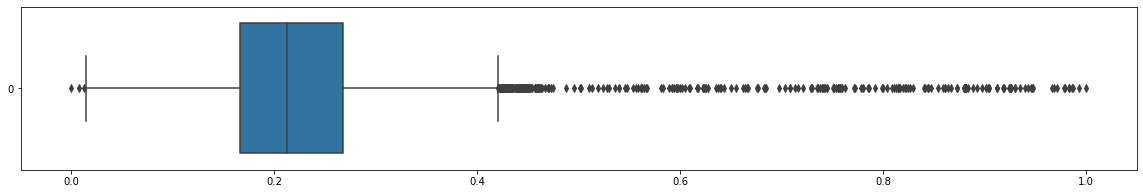

In [50]:
plt.figure(figsize = (20, 3))
ax = sns.boxplot(data = y_train, orient = 'h')

**TODO:** Elimine los valores atipicos superiores en la variable objetivo y entrene un nuevo modelo.

*Tip: Para determinar los valores atípicos a remover puede aplicar las reglas  $$outlier > Q3 + 1.5*IQR$$*  y $$outlier < Q1 - 1.5*IQR$$*

### 8.4 Varianza constante (Homocedasticidad)

Este supuesto exige que la varianza en los errores se mantenga constante a medida que varia la variable objetivo. Al igual que los otros supuestos, la mejor forma de identificarlo es visualmente, graficando la variable objetivo contra los errores. 

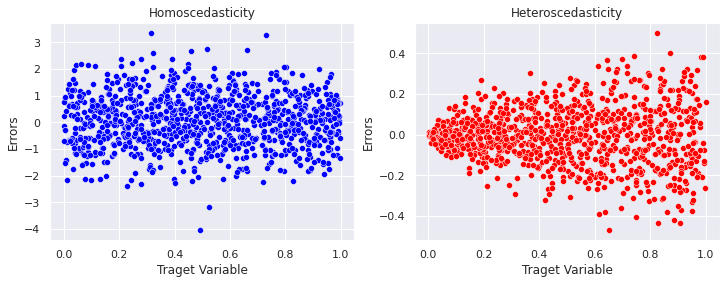

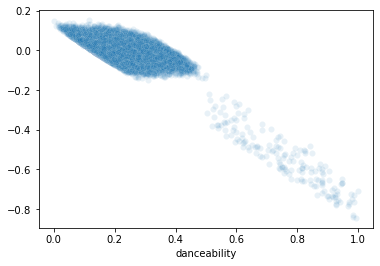

In [51]:
sns.scatterplot(x = y_train, y = errors, alpha = 0.1)

Una mala grafica puede indicar que se necesita una transformación, o que hace falta una variable extra.

**TODO:** Entrene un nuevo modelo que incorpore transformaciones polinomiales de todas las variables de entrada.

## 7. Persistencia del modelo y estimación para el nuevo conjunto de datos

In [52]:
filename = 'model.joblib'

In [53]:
dump(pipeline, filename)

['model.joblib']

In [54]:
pipeline_loaded = load(filename)

In [55]:
df_tracks_new['danceability'] = pipeline_loaded.predict(df_tracks_new[features])

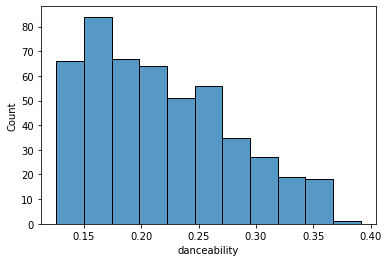

In [56]:
sns.histplot(df_tracks_new['danceability'])

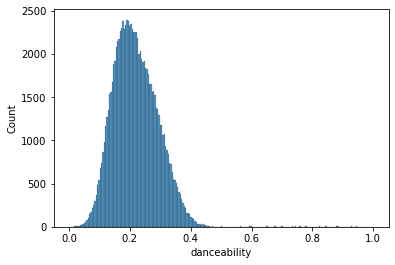

In [57]:
sns.histplot(df_tracks['danceability'])

Se puede observar que las estimaciones de `danceability` para el conjunto de datos nuevo se encuentran más o menos en el mismo rango de la variable original en el conjunto de datos usado para entrenar y validar el modelo.